In [13]:
import math
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline
import datetime
import tables 
import tstables  
import os
from indicators import *
from sklearn import svm

def write2excel( df, filename ):
    filepath = os.path.join('..', '..', 'datastore', filename) + '.xlsx'
    writer = pd.ExcelWriter(filepath, engine='xlsxwriter')
    df.to_excel(writer )
    writer.save()

In [14]:
symbol = 'AUD_USD'
account_type = 'practice'
granularity = 'S5'
start_datetime = datetime.datetime(2010,1,1,0,0,0)
end_datetime = datetime.datetime(2015,1,1,0,0,0)
decision_frequency = '4H'

file_path = '..\\..\\datastore\\_{0}\\{1}\\{2}.h5'.format(account_type,symbol,granularity)

h5 = tables.open_file(file_path, 'r')
ts = h5.root.data._f_get_timeseries()
raw = ts.read_range(start_datetime,end_datetime)
raw = pd.DataFrame(raw)
                
# Aggregate the high frequency data to the decision frequency
ohlc_dict = {   'ask_o':'first', 'ask_h':'max', 'ask_l':'min', 'ask_c': 'last',                                                                                                    
                'bid_o':'first', 'bid_h':'max', 'bid_l':'min', 'bid_c': 'last',                                                                                                    
                'volume': 'sum' }

df = raw.resample(decision_frequency, closed='left', label='left').apply(ohlc_dict).dropna()

indicator_list = []


In [15]:
#df.bid_c.plot()
#plt.show()

file_path_csv = '..\\..\\datastore\\_{0}\\{1}\\AUD3.csv'.format(account_type,symbol,granularity)
df.to_csv(file_path_csv)


In [16]:
sma_value = 50
df['SMA{}'.format(sma_value)] = talib.SMA(df['bid_c'].values,50)
df['diverge_from_sma'] = df['bid_c'] - df['SMA{}'.format(sma_value)]
df['RSI'] = talib.RSI(df['bid_c'].values, timeperiod=3)

lookback = 1
df['return'] = (df['bid_c']/df['bid_c'].shift(lookback))
df['return_class'] = np.where(df['return'] >= 1, 'UP', 'DOWN')
df['return_class_binary'] = np.where(df['return'] >= 1, 1, 0)

df['return_class_to_pred'] = df['return_class'].shift(-lookback)
df['return_class_binary_to_pred'] = df['return_class_binary'].shift(-lookback)
df = df.dropna()

In [17]:
df.tail()

,ask_o,ask_h,ask_l,ask_c,bid_o,bid_h,bid_l,bid_c,volume,SMA50,diverge_from_sma,RSI,return,return_class,return_class_binary,return_class_to_pred,return_class_binary_to_pred
2014-12-30 20:00:00,0.81807,0.81881,0.81788,0.81842,0.81787,0.81857,0.81769,0.81821,384.0,0.813825,0.004385,66.832975,1.000452,UP,1,UP,1.0
2014-12-31 00:00:00,0.81838,0.82165,0.81802,0.82023,0.81818,0.82149,0.81780,0.82005,1283.0,0.813943,0.006107,79.895129,1.002249,UP,1,DOWN,0.0
2014-12-31 04:00:00,0.82026,0.82084,0.81787,0.81868,0.82008,0.82064,0.81768,0.81847,729.0,0.813982,0.004488,53.006530,0.998073,DOWN,0,UP,1.0
2014-12-31 08:00:00,0.81871,0.82090,0.81858,0.82075,0.81852,0.82069,0.81838,0.82054,1038.0,0.814025,0.006515,71.714230,1.002529,UP,1,DOWN,0.0
2014-12-31 12:00:00,0.82079,0.82114,0.81600,0.81835,0.82057,0.82096,0.81583,0.81816,1564.0,0.814073,0.004087,42.520917,0.997099,DOWN,0,DOWN,0.0


In [19]:
training_data_size = int(df.index.values.size * .60 )
train, test = df[0:training_data_size], df[training_data_size:df.index.values.size]


In [20]:
X_train = train[['diverge_from_sma','RSI']].values
X_test = test[['diverge_from_sma','RSI']].values
#y_train = train[['return_class_to_pred']].values
y_train = train[['return_class_binary_to_pred']].values
y_test = test[['return_class_binary_to_pred']].values



In [21]:
clf = svm.SVC(kernel='rbf', C = 1.0, gamma=0.5)
clf.fit(X_train,y_train)

C:\Users\bora\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
#y_pred = clf.predict(X_test)
#y_pred

accuracy = clf.score(X_test, y_test)
print(accuracy)

0.484379562044


In [23]:
accuracy = clf.score(X_train, y_train)
print(accuracy)

0.570872274143


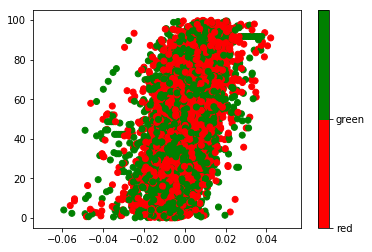

In [24]:
colors = ['red','green']
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(y_train),max(y_train)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)